In [1]:
from pathlib import Path
import torch
import numpy as np
import os

from torch import cuda
import pytorch_lightning as pl
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
import seaborn as sns
import matplotlib.pyplot as plt

os.chdir("..")
from utils import io
from models import SegmentationModel_1
from models import SegmentationModel_2

/home/students/s265780/.conda-envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# gt(0.1)   reports/unet_2/unet_1/1-epoch=64-val_loss_segm=0.11-v4.ckpt
# gt(0.5)   reports/unet_1/unet_1/1-epoch=64-val_loss_segm=0.11.ckpt
# L1   reports/unet_2/unet_1/1-epoch=64-val_loss_segm=0.11-v5.ckpt

model_1 = SegmentationModel_1.load_from_checkpoint(Path("reports/unet_2/unet_1/1-epoch=64-val_loss_segm=0.11-v5.ckpt"))
model_1.eval();

In [3]:
input_path = Path("/home/students/s265780/data/24h_10mmMAX_OI")

test_date_9 = [
    "20190807", "20181030", "20200329", "20200501", "20190505", "20200128", "20180825",
    "20210807", "20210724", "20201006", "20210628", "20220518", "20190702", "20190802",
    "20210617", "20190806", "20200519", "20190618", "20180817", "20180801", "20190703",
    "20190714", "20220331", "20190906", "20181123", "20180720", "20200617", "20220524",
    "20190919", "20210730", "20190424", "20191218", "20200609", "20180607", "20181124",
    "20200801", "20210727", "20200420", "20211031", "20190828", "20190819", "20190412",
    "20200627", "20210101", "20181029", "20200701", "20200616", "20200426", "20180714",
    "20220528", "20200921", "20190908", "20200830", "20180813", "20191022", "20210831",
    "20180830", "20210712", "20191014", "20180820", "20190710", "20210129"
]

indices_one, indices_zero, mask = io.get_mask_indices(input_path, True) #why False?
case_study_max=483.717752
available_models = ["bol00", "e1000", "c2200", "c5m00"]
x, y, in_features, out_features = io.load_data('unet', input_path, test_date_9, case_study_max, indices_one, indices_zero, available_models)


In [4]:
sigmoid_threshold = 0.1
where_threshold = 0.001

logit_seg = model_1(torch.from_numpy(x).to('cuda'))

logit_seg_numpy = logit_seg.squeeze().to('cpu').detach().numpy()

#seg = torch.round(torch.sigmoid(logit_seg)).squeeze().to('cpu').detach().numpy()
seg = logit_seg.gt(sigmoid_threshold).squeeze().to('cpu').detach().numpy()

y_seg = np.squeeze(np.where(y>where_threshold, 1, 0))

Text(0.5, 1.0, 'parti bianche mancano, nere sono di troppo')

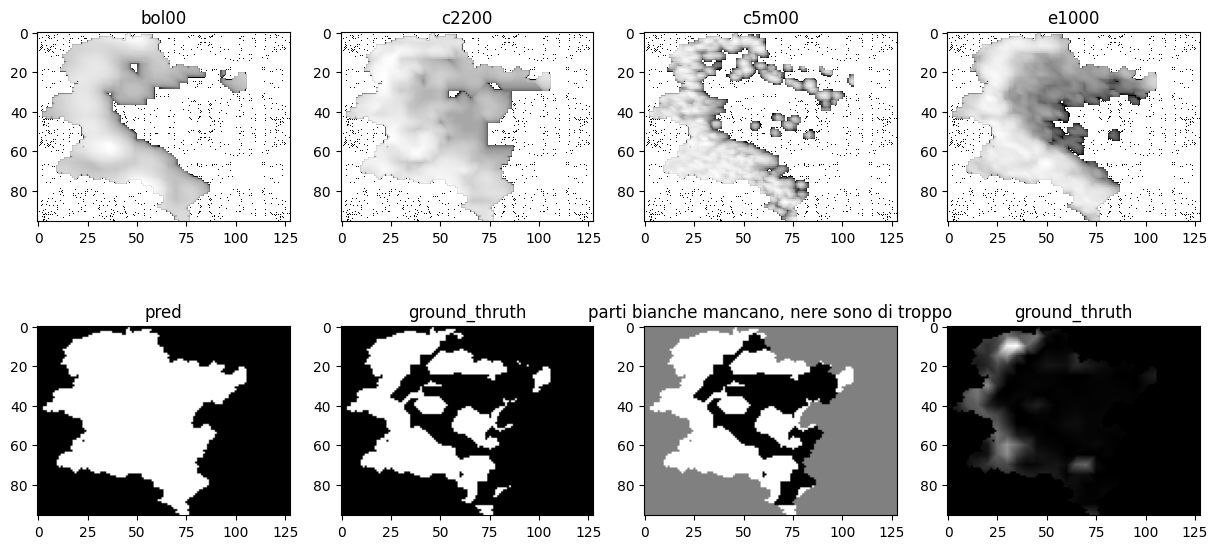

In [5]:
n=18
fig, axs = plt.subplots(2, 4, figsize=(15, 7))
axs[0, 0].imshow(x[n][0], cmap='gray', norm='log')
axs[0, 0].set_title('bol00')
axs[0, 1].imshow(x[n][1], cmap='gray', norm='log')
axs[0, 1].set_title('c2200')
axs[0, 2].imshow(x[n][2], cmap='gray', norm='log')
axs[0, 2].set_title('c5m00')
axs[0, 3].imshow(x[n][3], cmap='gray', norm='log')
axs[0, 3].set_title('e1000')
axs[1, 3].imshow(y[n], cmap='gray', norm='linear')
axs[1, 3].set_title('ground_thruth')
axs[1, 0].imshow(seg[n], cmap='gray')
axs[1, 0].set_title('pred')
axs[1, 1].imshow(y_seg[n], cmap='gray')
axs[1, 1].set_title('ground_thruth')
axs[1, 2].imshow((y_seg[n]*2-seg[n])*mask, cmap='gray')
axs[1, 2].set_title('parti bianche mancano, nere sono di troppo')

In [6]:
intersection = seg[n] & y_seg[n]

tp = intersection.sum()
fp = (seg[n]-intersection).sum()
fn = (y_seg[n]-intersection).sum()

precision=tp/(tp+fp)
recall=tp/(tp+fn)

precision, recall

(0.6110158185629884, 1.0)

In [7]:
precision = []
recall = []
iou = []
thresholds = np.linspace(0.01, 0.99, 30)
for threshold in thresholds:
    seg = model_1(torch.from_numpy(x).to('cuda')).gt(threshold).squeeze().to('cpu').detach().numpy()
    intersection = seg & y_seg

    tp = intersection.sum()
    fp = (seg-intersection).sum()
    fn = (y_seg-intersection).sum()

    precision.append(tp/(tp+fp))
    recall.append(tp/(tp+fn))

    intersection = seg & y_seg
    union = seg | y_seg
    iou.append(intersection.sum() / union.sum())

#precision, recall, iou

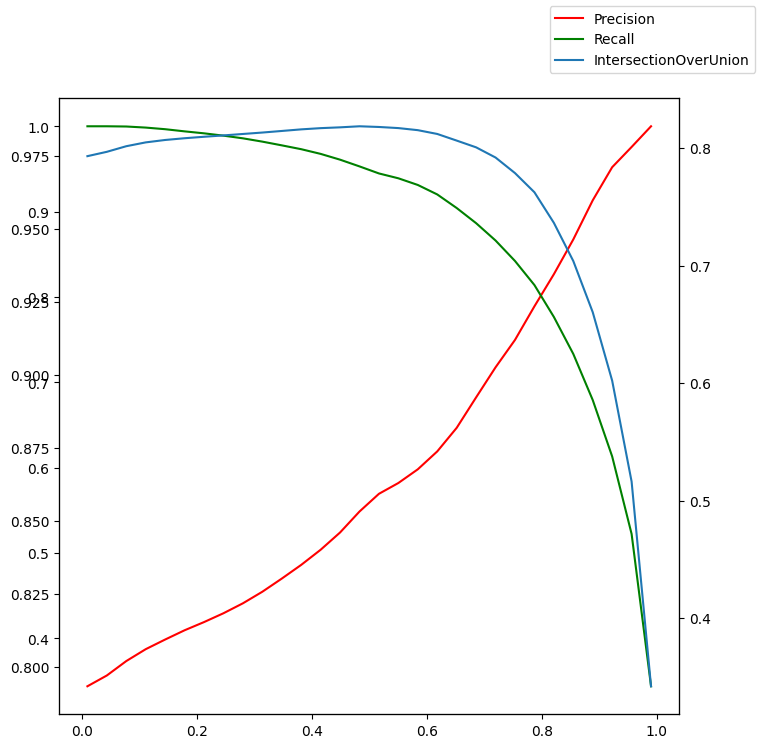

In [8]:
fig, ax1 = plt.subplots(figsize=(8, 8))
ax2 = ax1.twinx()
ax3 = ax2.twinx()

ax1.plot(thresholds, precision, c="r", label='Precision')
ax2.plot(thresholds, recall, c="g", label='Recall');
ax3.plot(thresholds, iou, label='IntersectionOverUnion');

fig.legend()
fig.show()

In [9]:
# gt(0.1) reports/unet_2/unet_2/2-epoch=86-val_loss=0.00-v8.ckpt
#gt(0.5)  reports/unet_2/unet_2/2-epoch=86-val_loss=0.00-v2.ckpt
# L1      reports/unet_2/unet_2/2-epoch=86-val_loss=0.00-v9.ckpt

model_2 = SegmentationModel_2.load_from_checkpoint(Path("reports/unet_2/unet_2/2-epoch=86-val_loss=0.00-v9.ckpt"))
model_2.eval();

In [17]:
logit = model_2(torch.from_numpy(x).to('cuda'), None)
logit = logit.squeeze().cpu().detach().numpy()

OutOfMemoryError: CUDA out of memory. Tried to allocate 94.00 MiB. GPU 0 has a total capacity of 15.77 GiB of which 7.12 MiB is free. Including non-PyTorch memory, this process has 11.83 GiB memory in use. Process 3312394 has 3.94 GiB memory in use. Of the allocated memory 11.13 GiB is allocated by PyTorch, and 339.94 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Text(0.5, 1.0, 'model_pred')

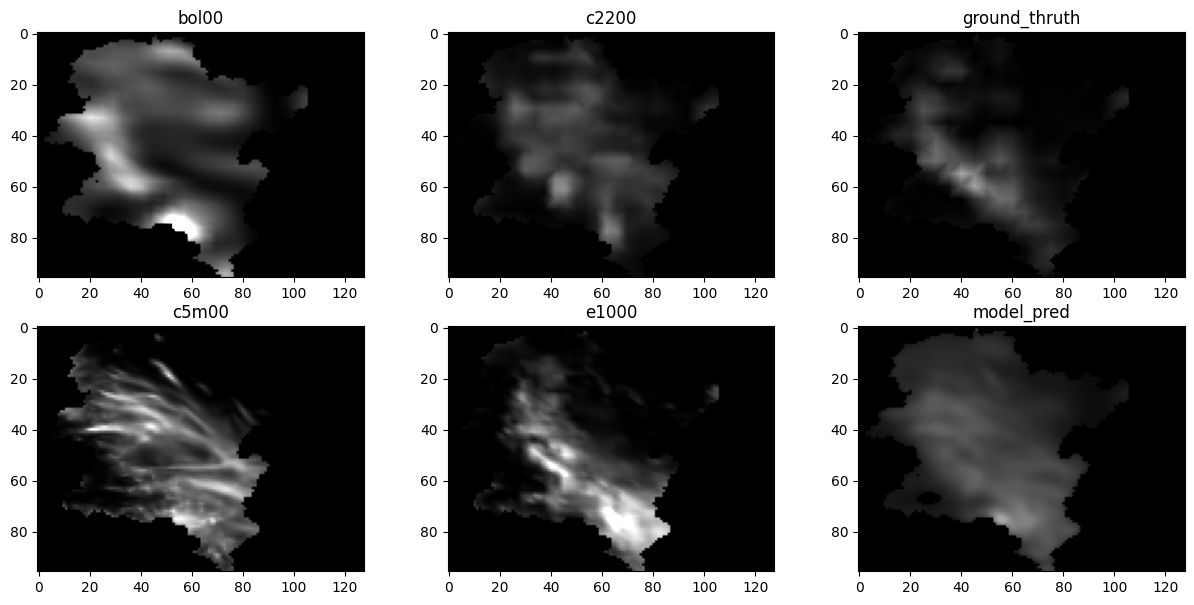

In [11]:
m=2
norm='linear'
vmin=0
vmax=1/20
fig, axs = plt.subplots(2, 3, figsize=(15, 7))
axs[0, 0].imshow(x[m][0], cmap='gray', norm=norm, vmin=vmin, vmax=vmax)
axs[0, 0].set_title('bol00')
axs[0, 1].imshow(x[m][1], cmap='gray', norm=norm, vmin=vmin, vmax=vmax)
axs[0, 1].set_title('c2200')
axs[1, 0].imshow(x[m][2], cmap='gray', norm=norm, vmin=vmin, vmax=vmax)
axs[1, 0].set_title('c5m00')
axs[1, 1].imshow(x[m][3], cmap='gray', norm=norm, vmin=vmin, vmax=vmax)
axs[1, 1].set_title('e1000')
axs[0, 2].imshow(y[m], cmap='gray', norm=norm, vmin=vmin, vmax=vmax)
axs[0, 2].set_title('ground_thruth')
axs[1, 2].imshow(logit[m], cmap='gray', norm=norm, vmin=vmin, vmax=vmax)
axs[1, 2].set_title('model_pred')

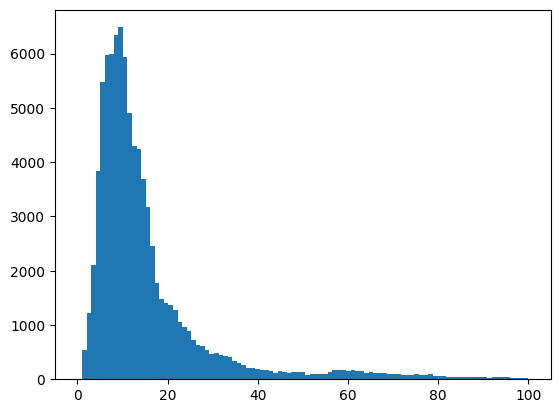

1.0181706

In [12]:
histo = (logit*case_study_max*seg).flatten()

plt.hist(histo[histo!=0], bins=np.linspace(0,100, 100))
plt.show()
histo[histo!=0].min()

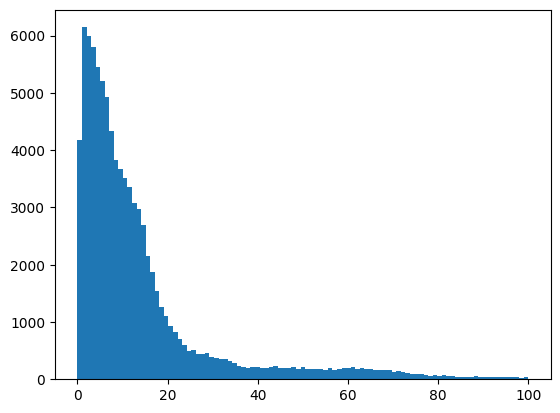

0.000390625

In [13]:
histo = (y*case_study_max*seg).flatten()

plt.hist(histo[histo!=0], bins=np.linspace(0,100, 100))
plt.show()
histo[histo!=0].min()